<a href="https://colab.research.google.com/github/werew/deep-trading/blob/main/trigger_on_random_walk_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import math
import random

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

%pip install wandb
import wandb

from google.colab import drive
drive.mount('/content/drive')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

project_name = 'trigger_on_random_walk'
project_dir = '/content/drive/MyDrive/Colab Notebooks'

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 139 kB 46.9 MB/s 
     |████████████████████████████████| 97 kB 6.3 MB/s 
     |████████████████████████████████| 180 kB 46.5 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=ce5a2ad83eb64947587651924358b80b2ee8f502659ed5fc761a02f224a90ff3
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=b24bc7df758936d9c6edcb9d0d331eef30505af43a91c97f324723976e28c141
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using cpu devi

# Common

In [ ]:
class TimeSeriesDataset(Dataset):
  def __init__(self, x, y, raw, seq_len):
    self.x = x
    self.y = y
    self.raw = raw
    self.seq_len = seq_len

  def __len__(self):
    return self.x.shape[0] // self.seq_len

  def __getitem__(self, index):
    x = self.x[index * self.seq_len: (index+1) * self.seq_len]
    y = self.y[index * self.seq_len: (index+1) * self.seq_len]
    return (x, y)



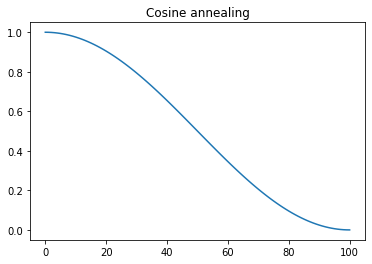

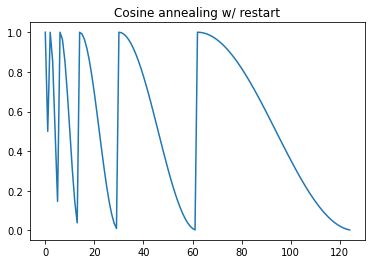

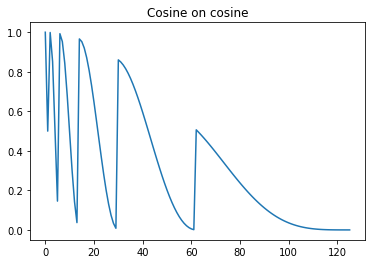

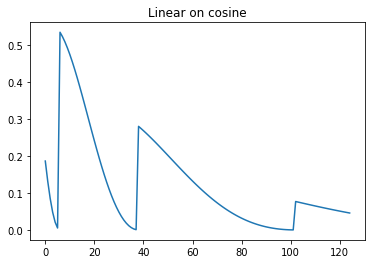

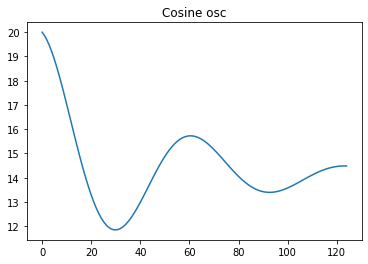

In [ ]:
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html
def cosine_annealing(start, T_max, eta_min=0, last_epoch=0):
  n_min, n_max = eta_min, start
  T_cur = last_epoch
  while T_cur <= T_max:
    yield ((n_min + (n_max - n_min)) * (1 + math.cos(math.pi * T_cur / T_max))) / 2
    T_cur += 1

plt.title('Cosine annealing')
plt.plot(np.array(list(cosine_annealing(1, 100))))
plt.show()

def cosine_annealing_warm_restars(start, T_0, T_mult=1, eta_min=0, last_epoch=0):
  n_min, n_max = eta_min, start

  if T_mult == 1:
    T_cur = last_epoch % T_0
    T_i = T_0
  else:
    n = int(math.log((last_epoch / T_0 * (T_mult - 1) + 1), T_mult))
    T_cur = last_epoch - T_0 * (T_mult ** n - 1) / (T_mult - 1)
    T_i = T_0 * T_mult ** n

  while True:
    yield ((n_min + (n_max - n_min)) * (1 + math.cos(math.pi * T_cur / T_i))) / 2

    T_cur += 1
    if T_cur >= T_i:
      T_cur -= T_i
      T_i *= T_mult

    last_epoch += 1

plt.title('Cosine annealing w/ restart')
g = cosine_annealing_warm_restars(1, 1, 2, last_epoch=1)
plt.plot([next(g) for i in range(125)])
plt.show()

def cosine_on_cosine(start, periods, T_0, T_mult=1, eta_min=0, last_epoch=0):
  T_max = int(T_0 * (1 - T_mult ** (periods + 1)) / (1 - T_mult))
  c = cosine_annealing(1, T_max=T_max, last_epoch=last_epoch)
  wr = cosine_annealing_warm_restars(start, T_0, T_mult=T_mult, eta_min=eta_min, last_epoch=last_epoch)
  for _ in range(T_max - last_epoch):
    cy = next(c)
    yield cy * next(wr)


plt.title("Cosine on cosine")
cc = cosine_on_cosine(1, 6, 1, 2, last_epoch=1)
plt.plot(list(cc))
plt.show()

def linear_on_cosine(start, coef, T_0, T_mult=1, eta_min=0, last_epoch=0):
  wr = cosine_annealing_warm_restars(start, T_0, T_mult=T_mult, eta_min=eta_min, last_epoch=last_epoch)
  while True:
    yield next(wr) * (coef ** last_epoch)
    last_epoch += 1


plt.title("Linear on cosine")
lc = linear_on_cosine(1, 0.98, 1, 2, last_epoch=25)
plt.plot([ next(lc) for _ in range(125)])
plt.show()


def cosine_osc(target, upper, lower, last_epoch=0, a=0.98, osc=0.2):
  while True:
    cos = math.cos(last_epoch * osc)
    k = (a ** last_epoch) * cos / 2 + target

    if cos > 0:
      yield k + (a ** last_epoch)*(cos*upper - cos*target)
    else:
      yield k + (a ** last_epoch)*(cos*lower + cos*target)
    last_epoch += 1


def cosine_osc(target, upper, lower, last_epoch=0, annealing_coef=0.98, freq_coef=0.1):
  while True:
    c = math.cos(last_epoch * freq_coef)
    a = (annealing_coef ** last_epoch)

    u = target + (upper - target)*a
    l = target - (target - lower)*a
    k = (a * c * (upper - lower) + u + l) / 2
    yield k
    last_epoch += 1

plt.title("Cosine osc")
g = cosine_osc(14, 20, 10, last_epoch=0)
plt.plot([ next(g) for _ in range(125)])
plt.show()

# Dataset setup


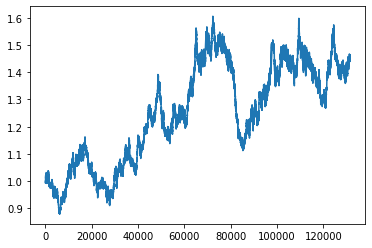

In [ ]:
MEAN_BTC_BUSD_RETURNS = 2.357400880745937e-06
STD_BTC_BUSD_RETURNS = 0.0012172864564457021

# Gaussian random walk
def random_walk(size, start=1, feature_range=(-1,1), mean=MEAN_BTC_BUSD_RETURNS, std=STD_BTC_BUSD_RETURNS):
  # List of step sizes
  returns = torch.normal(mean,std, (size,1))

  # Apply stepsizes starting from `start`
  values = torch.zeros(returns.shape)

  values[0] = start
  for i in range(1,len(values)):
    values[i] = values[i-1]*(1 + returns[i])
  return values

plt.plot(random_walk(365*30*12))

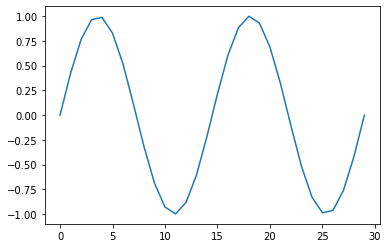

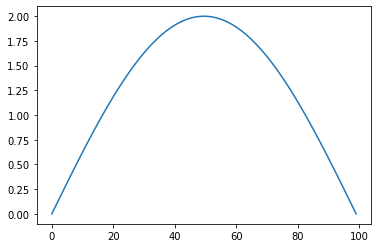

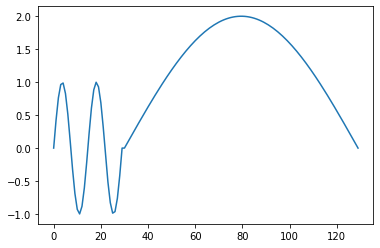

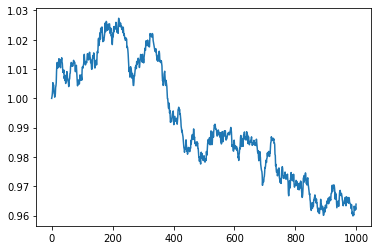

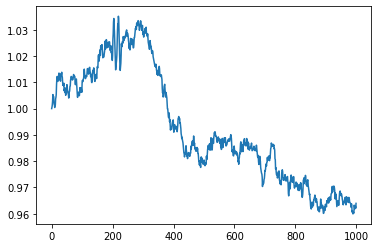

In [ ]:
# Signal that precedes a price raise
trigger = torch.sin(torch.linspace(0,np.pi*2*2, 30)).view(-1,1)
plt.plot(trigger)
plt.show()

# Temporaru price raise
effect = torch.sin(torch.linspace(0,np.pi, 100)).view(-1,1) * 2
plt.plot(effect)
plt.show()

# Full set of events
trigger_effect = torch.cat([trigger,effect])
plt.plot(trigger_effect)
plt.show()

# Example of random walk w/o and w/ trigger-event sequencece
rw = random_walk(1000)
plt.plot(rw)
plt.show()

i = 200
rw[i:i+len(trigger_effect)] += trigger_effect * 0.01
plt.plot(rw)
plt.show()

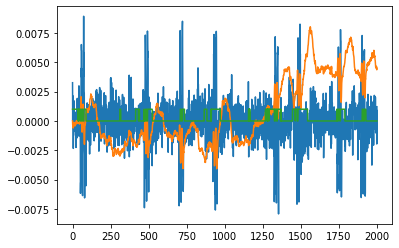

In [ ]:
RETURNS_WINDOW = 60

# Dataset
def gen_dataset(size):
  x = random_walk(size)
  y = torch.zeros((size,1))

  def try_add(tensor, i, values):
    if len(tensor[i:]) <= len(values):
      return False
    tensor[i:i+len(values)] += values
    return True

  def get_label(s):
    if len(s) < 2:
      return 0

    # Relative returns wrt the start
    s = (s[1:] - s[0]) / s[0]

    if s[:RETURNS_WINDOW].max().item() > 0.02:
        return 1
    return 0

  i = 0
  te = trigger_effect * 0.015
  while i < size:
    if random.random() < 0.005:
      try_add(x,i,te)
      i += len(te)
      continue
    i += 1

  i = 0
  win = 200
  while i < size:
    y[i] = get_label(x[i:i+win])
    i += 1

  raw = x
  x = (x / x.roll(-1) - 1)
  return x[:-1], y[:-1], raw[:-1]

def make_or_load_datasets():
  data_path = f'{project_dir}/{project_name}_dataset.pt'
  if os.path.exists(data_path):
    return torch.load(data_path)

  data = {}
  data['train_x'], data['train_y'], data['train_raw'] = gen_dataset(365*24*60)
  data['dev_x'], data['dev_y'], data['dev_raw'] = gen_dataset(int(365*24*60*0.2))
  data['test_x'], data['test_y'], data['test_raw'] = gen_dataset(int(365*24*60*0.2))
  torch.save(data, data_path)
  return data

datasets = make_or_load_datasets()

plt.plot(datasets['train_x'][:2000])
plt.plot((datasets['train_raw'][:2000]-1) * 0.1)
plt.plot(datasets['train_y'][:2000]*0.001)
plt.show()

# Move datasets to selected device
for k, v in datasets.items():
  datasets[k] = v.to(device)

# Training setup

In [ ]:
class Model(nn.Module):

 def __init__(self):
   super(Model, self).__init__()
   self.lstm = nn.LSTM(input_size=1, hidden_size=200, batch_first=True, num_layers=1)
   self.leaky_relu = nn.LeakyReLU()
   self.lstm2 = nn.LSTM(input_size=200, hidden_size=100, batch_first=True, num_layers=1)
   self.leaky_relu2 = nn.LeakyReLU()
   self.linear = nn.Linear(in_features=100, out_features=1)
   self.hidden_state = None

 def forward(self, x, h=None):
   x, self.hidden_state = self.lstm(x, h)
   x = self.leaky_relu(x)
   x, _ = self.lstm2(x)
   x = self.leaky_relu2(x)
   x = self.linear(x)
   return x

#   def __init__(self):
#     super(Model, self).__init__()
#     self.lstm = nn.LSTM(input_size=1, hidden_size=50, batch_first=True, num_layers=1)
#     self.leaky_relu = nn.LeakyReLU()
#     self.linear = nn.Linear(in_features=50, out_features=1)
#     self.hidden_state = None

#   def forward(self, x, h=None):
#     x, self.hidden_state = self.lstm(x, h)
#     x = self.leaky_relu(x)
#     x = self.linear(x)
#     return x

def load_model(version):
  model = Model()
  model_path = f'{project_dir}/{project_name}_model_{version}.pt'
  model.load_state_dict(torch.load(model_path))
  return model

def save_model(model, version):
  model_path = f'{project_dir}/{project_name}_model_{version}.pt'
  torch.save(model.state_dict(), model_path)

In [ ]:
def test_trading(params, preds):
  prices = params['prices']
  t = params['hyperparams']['threshold']
  position = None
  returns = []
  pct_change = lambda a,b: (b-a) / a

  for i, (price, pred) in enumerate(zip(prices.view(-1), preds.view(-1))):
    price, pred = price.item(), pred.item()

    if pred > t:
      if position is None:
        position = {'i':i, 'price':price} # Buy
      else:
        position['i'] = i # Update for timeout
      continue

    if position is None:
      continue

    roi = pct_change(position['price'], price)
    if roi >= 0.2 or roi <= -0.1 or i > position['i'] + RETURNS_WINDOW*2:
      position = None
      returns.append(roi)

  returns = torch.tensor(returns)
  return {
      'number_returns': len(returns),
      'total_returns': returns.sum().item(),
      'std_returns': returns.std().item(),
      'mean_returns': returns.mean().item(),
      'median_returns': returns.median().item(),
  }

def get_metrics(params, pred):
    pred = torch.sigmoid(pred)
    t = params['hyperparams']['threshold']

    res = {
      'tp': ((pred > t) & (params['y'] == 1.)).sum().item(),
      'fp': ((pred > t) & (params['y'] == 0.)).sum().item(),
      'tn': ((pred <= t) & (params['y'] == 0.)).sum().item(),
      'fn': ((pred <= t) & (params['y'] == 1.)).sum().item(),
    }

    if 'prices' in params:
      res['trading'] = test_trading(params, pred)

    return res

def get_precision_recall(res):
  e = 0.0000000000001
  return {
    f'precision': (
        res['tp'] / (res['tp'] + res['fp'] + e)
    ),
    f'recall': (
        res['tp'] / (res['tp'] + res['fn'] + e)
    ),
  }

def train_loop(params, dataloader):
    num_batches = len(dataloader)
    avg_loss = 0

    res = {}
    res['loss'] = 0

    for batch, (x, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = params['model'](x)
        loss = params['loss_fn'](pred, y)
        avg_loss += loss.item()

        # Backpropagation
        params['optimizer'].zero_grad()
        loss.backward()
        params['optimizer'].step()

        # Get more metrics
        tmp_params = {'x': x, 'y': y, **params}
        for k,v in get_metrics(tmp_params, pred).items():
          if k not in res:
            res[k] = 0
          # Add up all metrics
          res[k] += v

        # Add up loss
        res['loss'] += loss.item()

        if batch % 20 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{num_batches:>5d}]")

    res['loss'] /= num_batches
    res.update(get_precision_recall(res))

    return res

def test_single(params, include_pred=False):
    pred = params['model'](params['x'])
    res = get_metrics(params, pred)

    res['loss'] = params['loss_fn'](pred, params['y']).item()
    if include_pred:
      res['pred'] = pred

    return res

def test_loop(params, dataloader, batching=False, trading=False):

    num_batches = len(dataloader)
    res = {}

    with torch.no_grad():

      ####################
      # Test w/ batching #
      ####################
      if batching:
        res['batching'] = {}
        for x, y in dataloader:

          tmp_params = {'x': x, 'y': y, **params}
          for k,v in test_single(tmp_params).items():

            # Add key if not present
            if k not in res['batching']:
              res['batching'][k] = 0

            # Add up metrics
            res['batching'][k] += v

        # Average loss across batches
        res['batching']['loss'] /= num_batches
        res['batching'].update(get_precision_recall(res['batching']))

      #####################
      # Test w/o batching #
      #####################
      tmp_params = {
        'x': dataloader.dataset.x.unsqueeze(dim=0),
        'y': dataloader.dataset.y.unsqueeze(dim=0),
        **params
      }
      if trading:
        tmp_params['prices'] = dataloader.dataset.raw.unsqueeze(dim=0)
      res['no_batching'] = test_single(tmp_params)
      res['no_batching'].update(get_precision_recall(res['no_batching']))

    return res

In [ ]:
# We start at epoch zero
epoch = 0

# Init W&B run
#wandb_run = wandb.init(project=project_name)

# Load model
model = load_model('logical-bush-8')
#model = Model()
model.to(device)

Model(
  (lstm): LSTM(1, 200, batch_first=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (lstm2): LSTM(200, 100, batch_first=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.01)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [ ]:

pos = datasets['train_y'].sum().item()
neg = datasets['train_y'].nelement() - pos

# Hyperparams
hyperparams = {
  'learning_rate': 0.000015,
  'batch_size': 64,
  'min_seq_len':450,
  'max_seq_len': 500,
  'pos_weight': (neg / pos) * 1.0,
  'threshold': 0.5,
}

params = {
  'hyperparams': hyperparams,
  'loss_fn': nn.BCEWithLogitsLoss(pos_weight=torch.tensor([hyperparams['pos_weight']]).to(device)),
  'optimizer': torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate']),
  'model': model,
}


# Training

In [ ]:
# Training
for _ in range(5):
  seq_len = random.randint(hyperparams['min_seq_len'], hyperparams['max_seq_len'])
  epoch += 1
  print(f"Epoch {epoch}, seq len: {seq_len}\n-------------------------------")

  # Train
  training_data = TimeSeriesDataset(datasets['train_x'], datasets['train_y'], datasets['train_raw'], seq_len)
  train_dataloader = DataLoader(training_data, batch_size=hyperparams['batch_size'], shuffle=True)

  train_res = train_loop(params, train_dataloader)

  # Test
  testing_data = TimeSeriesDataset(datasets['dev_x'], datasets['dev_y'], datasets['dev_raw'], seq_len)
  test_dataloader = DataLoader(testing_data, batch_size=hyperparams['batch_size'], shuffle=True)

  test_res = test_loop(params, test_dataloader)

  # Show some data
  print(
      f"\nTrain loss: {train_res['loss']}\n"
      f"Test no batching loss: {test_res['no_batching']['loss']}\n"
      f"Test no batching precision: {test_res['no_batching']['precision']}\n"
      f"Test no batching recall: {test_res['no_batching']['recall']}\n"
  )

  # Log results
  wandb_run.log({
    'epoch': epoch,
    'seq_len': seq_len,
    'train': train_res,
    'test': test_res,
    **hyperparams,
  })

Epoch 96, seq len: 459
-------------------------------
loss: 1.229284  [    0/   18]

Train loss: 1.2240844170252483
Test no batching loss: 1.5963636636734009
Test no batching precision: 0.19852332518244356
Test no batching recall: 0.9999520751461708

Epoch 97, seq len: 482
-------------------------------
loss: 1.165661  [    0/   18]

Train loss: 1.2136165897051494
Test no batching loss: 1.5965057611465454
Test no batching precision: 0.19614332997553605
Test no batching recall: 0.9798236365379086

Epoch 98, seq len: 467
-------------------------------
loss: 1.168174  [    0/   18]

Train loss: 1.2228890591197543
Test no batching loss: 1.59696364402771
Test no batching precision: 0.9970712658639765
Test no batching recall: 0.146841752132656

Epoch 99, seq len: 474
-------------------------------
loss: 1.254748  [    0/   18]

Train loss: 1.2247810694906447
Test no batching loss: 1.5969514846801758
Test no batching precision: 0.9971751412429378
Test no batching recall: 0.152257260615355

# Testing

In [ ]:
testing_data = TimeSeriesDataset(datasets['dev_x'], datasets['dev_y'], datasets['dev_raw'], 500)
test_dataloader = DataLoader(testing_data, batch_size=hyperparams['batch_size'], shuffle=True)
test_loop(params, test_dataloader, batching=True, trading=True)

{'batching': {'fn': 17337,
  'fp': 49,
  'loss': 1.5734350681304932,
  'precision': 0.9863051984348798,
  'recall': 0.16912680916323206,
  'tn': 84085,
  'tp': 3529},
 'no_batching': {'fn': 17172,
  'fp': 50,
  'loss': 1.5968892574310303,
  'precision': 0.9866452991452992,
  'recall': 0.17703441004504936,
  'tn': 84203,
  'tp': 3694,
  'trading': {'mean_returns': 0.010638535022735596,
   'median_returns': 0.01053091324865818,
   'number_returns': 318,
   'std_returns': 0.015574888326227665,
   'total_returns': 3.383054256439209}}}

In [ ]:
testing_data = TimeSeriesDataset(datasets['test_x'], datasets['test_y'], datasets['test_raw'], 500)
test_dataloader = DataLoader(testing_data, batch_size=hyperparams['batch_size'], shuffle=True)
test_loop(params, test_dataloader, batching=True, trading=True)

{'batching': {'fn': 16237,
  'fp': 46,
  'loss': 1.5396353006362915,
  'precision': 0.9863339275103981,
  'recall': 0.1697601881679194,
  'tn': 85397,
  'tp': 3320},
 'no_batching': {'fn': 16082,
  'fp': 47,
  'loss': 1.5401815176010132,
  'precision': 0.9866553094832482,
  'recall': 0.17768573912154215,
  'tn': 85515,
  'tp': 3475,
  'trading': {'mean_returns': 0.012085789814591408,
   'median_returns': 0.011525474488735199,
   'number_returns': 313,
   'std_returns': 0.016043879091739655,
   'total_returns': 3.7828521728515625}}}

In [ ]:
save_model(model, wandb_run.name)

In [ ]:
with torch.no_grad():
  pred_raw = model(datasets['dev_x'].unsqueeze(dim=0))
  pred = torch.sigmoid(pred_raw)

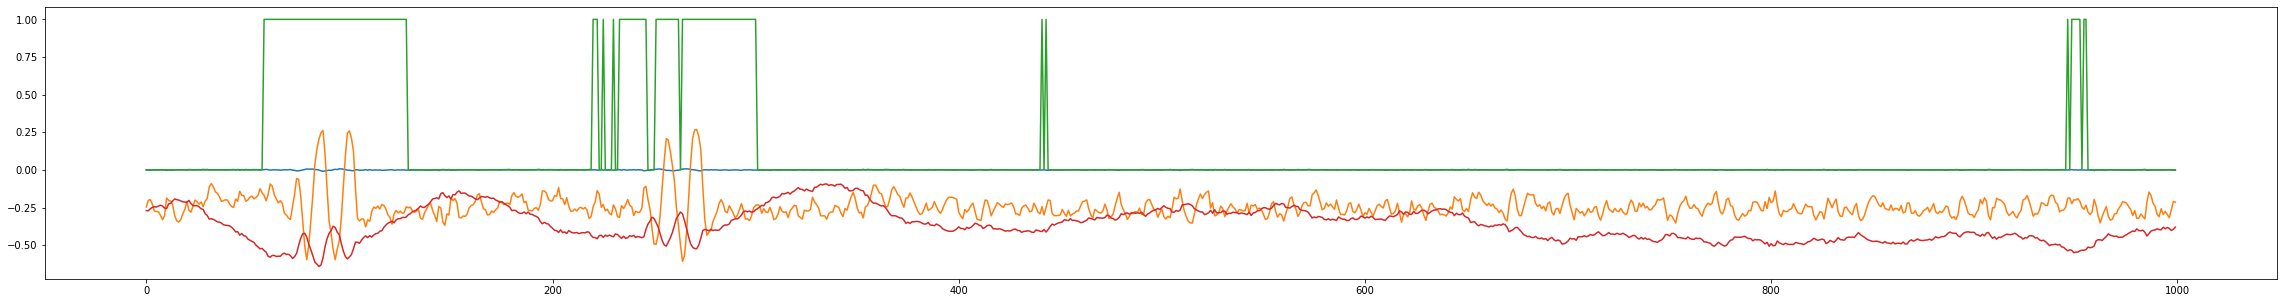

In [ ]:
plt.rcParams['figure.figsize'] = [40, 5]
w = 1000
s = w*51
e = s+w
plt.plot(datasets['dev_x'][s:e].cpu())
plt.plot((pred[0][s:e]*2000-1000).cpu() )
plt.plot((datasets['dev_y'][s:e]).cpu())
plt.plot((datasets['dev_raw'][s:e]*8 - 8.495).cpu())
plt.show()

In [ ]:
(pred > 0.985).sum()

tensor(122, device='cuda:0')

TODO
- try on more difficult dataset
  - add gaussian noise to the data
  - randomly remove some datapoints
- positive weight annealing at each epoch
  - reference weight is w = neg/pos, actual weight is w*c where c is a dynamic coefficient  
  - start with an high coef (e.g. 1.3): force the net into learning positive sequences
  - slowly decrease the coef (e.g. to 0.1): reduce false positives at the cost of false negatives
  - (maybe) slowly increase again (e.g. the coef could be oscilating)
- add learnig rate decay (https://stackoverflow.com/questions/39517431/should-we-do-learning-rate-decay-for-adam-optimizer)
- use a dataset closer to the trading data (longer series of 1s)